In [17]:
import pickle
import nltk
import math
import os
import pandas as pd

In [18]:

class vect:
    SCALAR = 1
    COSINE = 2
    JACCARD = 3
    
class Docs:
    def __init__(self):
        self.origin = "./PRJfixeddata/Documents/"

        files = os.listdir(self.origin)
        self.txt_files = [file for file in files if file.endswith(".txt")]
    
    def build(self,Lancaster=True,split=False):
        
        docs = []
        self.maxfreq = {}
        MotsVides = nltk.corpus.stopwords.words('english')
        self.Lancaster = Lancaster
        self.split = split
        
        file = ""
        my_dict = {}
        for i in range(len(self.txt_files)):
            file = open(self.origin+self.txt_files[i]).read()
            file = file.replace("\n","")

            Termes = self.splitter(file)

            TermesSansMotsVides = [terme for terme in Termes if terme.lower() not in MotsVides]
            TermesNormalisation = [self.normalize(terme) for terme in TermesSansMotsVides]

            for term in TermesNormalisation:
                if (term.lower(),i) in my_dict:
                    my_dict[(term,i)] += 1
                else:
                    my_dict[(term,i)] = 1

        self.freqDict = my_dict

        for keys in self.freqDict.keys():
            if keys[1] not in docs:
                docs.append(keys[1])
            if keys[1] not in self.maxfreq.keys():
                self.maxfreq[keys[1]] = 0
            if self.freqDict[keys] > self.maxfreq[keys[1]]:

                self.maxfreq[keys[1]] = self.freqDict[keys]
        self.N = len(docs)
        self.DictWeight()
    def buildFrom(self,weightDict=None,freqDict=None,maxfreq=None,N=None,Lancaster=True,split=False):
        MotsVides = nltk.corpus.stopwords.words('english')
        self.weightDict = weightDict
        self.freqDict = freqDict
        self.maxfreq = maxfreq
        self.N = N
        self.Lancaster = Lancaster
        self.split = split
        
        self.TDFP_DTFP()
    def TDFP_DTFP(self):
        self.TDFP = []
        self.DTFP = []
        for key in self.freqDict.keys():
            self.TDFP.append((key[0],key[1],self.freqDict[key],self.weightDict[key]))
            self.DTFP.append((key[1],key[0],self.freqDict[key],self.weightDict[key]))        
    def normalize(self,text):
        if self.Lancaster :
            Lancaster = nltk.LancasterStemmer()
            text = Lancaster.stem(text)
        else :
            porter = nltk.PorterStemmer()
            text = porter.stem(text)
        return text
    def splitter(self,text):
        if not self.split:
            return text.split(" ")
        else:
            ExpReg = nltk.RegexpTokenizer('(?:[A-Za-z]\.)+|[A-Za-z]+[\-@]\d+(?:\.\d+)?|\d+[A-Za-z]+|\d+(?:[\.\,]\d+)?%?|\w+(?:[\-/]\w+)*') # \d : équivalent à [0-9] >>> 
            Termes = ExpReg.tokenize(text) 
            return Termes
    def calcWeight(self,word,doc):

        inDocs = []

        for keys in self.freqDict.keys():
            if keys[0] == word:
                if keys[1] not in inDocs:
                    inDocs.append(keys[1])

        # nombre de documents contenant le mot
        Ni = len(inDocs)

        try:
            tf = self.freqDict[(word,doc)]/self.maxfreq[doc]
        except:
            tf = 0
            
        #idf = math.log10((N/Ni)+1)
        try:
            idf = math.log10((self.N/Ni)+1)
        except:
            idf = 0

        return(tf*idf)
    def DictWeight(self):
        self.TDFP = [(word,doc,self.freqDict[(word,doc)],self.calcWeight(word,doc)) for word,doc in self.freqDict.keys()]
        self.DTFP = [(doc,word,freq,weight) for word,doc,freq,weight in self.TDFP]
        self.TDFP = sorted(self.TDFP, key=lambda x: x[0])
        self.DTFP = sorted(self.DTFP, key=lambda x: x[0])
        self.weightDict = {}
        for word,doc,freq,weight in self.TDFP:
            self.weightDict[(word,doc)] = weight
    def MV(self,termes,typeV = vect.SCALAR):
        rsv = {}
        termes = self.splitter(termes)
        normterms = []
        for term in termes:
            normterms.append(self.normalize(term))

        for doc in range(self.N):
            QD = 0
            v2 = 0
            w2 = 0

            for term in normterms:
                if (term.lower(),doc) in self.freqDict.keys():
                    weight = self.weightDict[(term.lower(),doc)]
                    QD+= weight
                    w2+= weight**2
                    v2+= 1**2
            try:
                if typeV == vect.COSINE:
                    QD = QD / (math.sqrt(v2)*math.sqrt(w2))
                if typeV == vect.JACCARD:
                    QD = QD / (w2+v2 - QD)
            except ZeroDivisionError:
                QD = 0
            rsv[doc] = QD

        rsv = dict(sorted(rsv.items(), key=lambda item: item[1],reverse=True))
        return rsv
    def bm25(self,termes,K,B):
        rsv = {}
        #tokenization de la requete
        termes = self.splitter(termes)
        normterms = []
        dls = {}
        #normalisation de la requete 
        for term in termes:
            normterms.append(self.normalize(term.lower()))

        # calcule nombre termes par doc
        for term,doc in self.freqDict.keys():
            if doc in dls.keys():
                dls[doc] += self.freqDict[(term,doc)]
            else:
                dls[doc] = self.freqDict[(term,doc)]

        # moyenne des termes par doc
        avdl = 0
        for key in dls.keys():
            avdl += dls[key]
        avdl = avdl / len(dls.keys())

        for doc in range(self.N):
            rsv[doc] = 0
            for term in normterms:
                if (term,doc) in self.freqDict.keys():
                    ni = 0
                    for doc2 in range(self.N):
                        if (term,doc2) in self.freqDict.keys():
                            ni+=1

                    freq = self.freqDict[(term,doc)]
                    log = math.log10((self.N - ni + 0.5) / (ni + 0.5))
                    val = freq + K*((1-B)+(B*dls[doc]/avdl))
                    val = freq/val
                    rsv[doc] += val*log
        
        #trie du dictionnaire
        rsv = dict(sorted(rsv.items(), key=lambda item: item[1],reverse=True))
        return rsv
    def boolean(self,text):
        text = self.splitter(text)
        docText = {}
        for doc in range(self.N):
            copy = text.copy()
            lexique = [" * "," - "," + "," 1 "]
            copy = [" * " if item == "AND" else item for item in copy]
            copy = [" - " if item == "NOT" else item for item in copy]
            copy = [" + " if item == "OR" else item for item in copy]
            copy = [" 1 " if (self.normalize(item),doc) in self.freqDict.keys() else item for item in copy]
            copy = [" 0 " if item not in lexique  else item for item in copy]
            new_copy = []
            i=0
            while(i<len(copy)):
                if copy[i] == " - " and copy[i+1] == " 0 ":
                    new_copy.append(" 1 ")
                    i+=2
                elif copy[i] == " - " and copy[i+1] == " 1 ":
                    new_copy.append(" 0 ")
                    i+=2
                else:
                    new_copy.append(copy[i])
                    i+=1
            docText[doc] = 1 if eval("".join(new_copy)) > 0 else 0
        return docText


<>:78: SyntaxWarning: invalid escape sequence '\.'
<>:78: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Mekki\AppData\Local\Temp\ipykernel_2660\284390420.py:78: SyntaxWarning: invalid escape sequence '\.'
  ExpReg = nltk.RegexpTokenizer('(?:[A-Za-z]\.)+|[A-Za-z]+[\-@]\d+(?:\.\d+)?|\d+[A-Za-z]+|\d+(?:[\.\,]\d+)?%?|\w+(?:[\-/]\w+)*') # \d : équivalent à [0-9] >>>


In [27]:
df = pd.read_csv("data/PorterSplit_DTFP.csv")

weight_dict = df.set_index(['Mot', 'Doc'])['Poids'].to_dict()
freq_dict = df.set_index(['Mot', 'Doc'])['Freq'].to_dict()
maxfreq = df.groupby('Doc')['Freq'].max().to_dict()
N = df["Doc"].max()

d = Docs()
d.buildFrom(weightDict=weight_dict,freqDict=freq_dict,maxfreq=maxfreq,N=N,Lancaster=False,split=False)
d.MV("document",vect.SCALAR)


{236: 1.084188155111624,
 288: 1.084188155111624,
 359: 1.084188155111624,
 362: 1.084188155111624,
 456: 1.084188155111624,
 700: 1.084188155111624,
 780: 1.084188155111624,
 857: 1.084188155111624,
 898: 1.084188155111624,
 906: 1.084188155111624,
 1272: 1.084188155111624,
 1342: 1.084188155111624,
 1495: 1.084188155111624,
 1529: 1.084188155111624,
 2166: 1.084188155111624,
 2478: 1.084188155111624,
 2515: 1.084188155111624,
 2586: 1.084188155111624,
 2639: 1.084188155111624,
 2761: 1.084188155111624,
 2772: 1.084188155111624,
 2807: 1.084188155111624,
 2842: 1.084188155111624,
 3213: 1.084188155111624,
 3297: 1.084188155111624,
 3302: 1.084188155111624,
 3522: 1.084188155111624,
 3728: 1.084188155111624,
 3989: 1.084188155111624,
 4114: 1.084188155111624,
 4271: 1.084188155111624,
 4415: 1.084188155111624,
 4535: 1.084188155111624,
 4536: 1.084188155111624,
 4566: 1.084188155111624,
 4706: 1.084188155111624,
 4924: 1.084188155111624,
 5016: 1.084188155111624,
 5350: 1.0841881551116

1 0


Exception in Tkinter callback
Traceback (most recent call last):
  File "d:\APPS\python\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Mekki\AppData\Local\Temp\ipykernel_2660\1946582376.py", line 47, in on_token_change
    search()
  File "C:\Users\Mekki\AppData\Local\Temp\ipykernel_2660\1946582376.py", line 10, in search
    table.delete(*table.get_children())
                  ^^^^^^^^^^^^^^^^^^^^
  File "d:\APPS\python\Lib\tkinter\ttk.py", line 1195, in get_children
    self.tk.call(self._w, "children", item or '') or ())
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
_tkinter.TclError: invalid command name ".!frame.!treeview"


1 1


Exception in Tkinter callback
Traceback (most recent call last):
  File "d:\APPS\python\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Mekki\AppData\Local\Temp\ipykernel_2660\1946582376.py", line 47, in on_token_change
    search()
  File "C:\Users\Mekki\AppData\Local\Temp\ipykernel_2660\1946582376.py", line 10, in search
    table.delete(*table.get_children())
                  ^^^^^^^^^^^^^^^^^^^^
  File "d:\APPS\python\Lib\tkinter\ttk.py", line 1195, in get_children
    self.tk.call(self._w, "children", item or '') or ())
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
_tkinter.TclError: invalid command name ".!frame.!treeview"


1 0
1 1


Exception in Tkinter callback
Traceback (most recent call last):
  File "d:\APPS\python\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Mekki\AppData\Local\Temp\ipykernel_2660\1946582376.py", line 119, in on_query_change
    P.append(max([p for r,p in zip(Ri,Pi) if r >= i/10]))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: max() iterable argument is empty
Exception in Tkinter callback
Traceback (most recent call last):
  File "d:\APPS\python\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Mekki\AppData\Local\Temp\ipykernel_2660\1946582376.py", line 79, in show_boolean_model
    docText = d.boolean(text)
              ^^^^^^^^^^^^^^^
  File "C:\Users\Mekki\AppData\Local\Temp\ipykernel_2660\284390420.py", line 206, in boolean
    docText[doc] = 1 if eval("".join(new_copy)) > 0 else 0
                        ^^^^^^^^^^^^

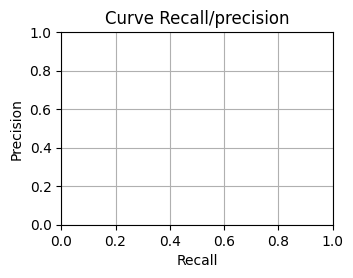

In [28]:
import tkinter as tk
from tkinter import ttk
from matplotlib import pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

def search():
    global stemming

    text = query_text.get()
    table.delete(*table.get_children())
    if index_var.get() == 0:
        data = d.TDFP
    else:
        data = d.DTFP

    if text == "":
        for terme in data:
            if type(terme[0]) is str:
                    table.insert("", "end", values=[terme[0],terme[1],terme[2],terme[3]])
            else:
                    table.insert("", "end", values=[terme[0],terme[1],terme[2],terme[3]])
        return
    
    searchText = d.splitter(text)
    searchText = [d.normalize(terme) for terme in searchText]

    for text in searchText:
        for terme in data:
            if type(terme[0]) is str:
                if text.lower() in terme[0].lower():
                    table.insert("", "end", values=[terme[0],terme[1],terme[2],terme[3]])
            else:
                if text.lower() in terme[1].lower():
                    table.insert("", "end", values=[terme[0],terme[1],terme[2],terme[3]])

def on_token_change(*args):
    global d
    print(stemming.get(),token.get())
    if stemming.get() == 1 and token.get() ==1:
        d = pickle.load(open("LancasterToken.p","rb"))
    if stemming.get() == 1 and token.get() ==0:
        d = pickle.load(open("LancasterSplit.p","rb"))
    if stemming.get() == 0 and token.get() ==1:
        d = pickle.load(open("PorterToken.p","rb"))
    if stemming.get() == 0 and token.get() ==0:
        d = pickle.load(open("PorterSplit.p","rb"))
    search()

def on_index_change(*args):
    search()

def show_match():
    text = query_text.get()
    table.delete(*table.get_children())

    if selected_option.get() == "SCALAR":
        rsv = d.MV(text,vect.SCALAR)
    if selected_option.get() == "COSINE":
        rsv = d.MV(text,vect.COSINE)
    if selected_option.get() == "JACCARD":
        rsv = d.MV(text,vect.JACCARD)

    for doc in rsv.keys():
        table.insert("", "end", values=[doc,"",rsv[doc],""])

def show_bm25():
    text = query_text.get()
    table.delete(*table.get_children())
    b = float(input_B.get())
    k = float(input_K.get())
    rsv = d.bm25(text,k,b)
    for doc in rsv.keys():
        table.insert("", "end", values=[doc,"",rsv[doc],""])

def show_boolean_model():
    global stemming
    table.delete(*table.get_children())
    text = query_text.get()
    docText = d.boolean(text)
    for doc in docText.keys():
        table.insert("", "end", values=[doc,"",docText[doc],""])

def show_datamining_model():
    pass

def on_query_change(*args):
    if run_queries.get() == 1:
        query_text.config(state="normal")
        text = queries[int(spinbox_var.get())]
        query_text.delete(0, tk.END)  # Clear the current content of the Entry widget
        query_text.insert(0, text)  # Set the new value
        query_text.config(state="readonly")


        total_revealent_documents = len([judgement for judgement in judgements if judgement[0] == (int(spinbox_var.get())+1)])
        total_documents = len(set([judgement[1] for judgement in judgements]))
        relevant_documents = [judgement[1] for judgement in judgements if judgement[0] == (int(spinbox_var.get())+1)]
        bin_relevant_documents = [1 if doc in relevant_documents else 0 for doc in range(1,11)]
        p = len(relevant_documents)/total_documents
        p5 = len(relevant_documents)/5
        p10 = len(relevant_documents)/10
        r = len(relevant_documents)/total_revealent_documents
        f = 2*((p*r)/(p+r))
        metriques_dict["precision"].config(text=str(p))
        metriques_dict["p@5"].config(text=str(p5))
        metriques_dict["p@10"].config(text=str(p10))
        metriques_dict["recall"].config(text=str(r))
        metriques_dict["fmeasure"].config(text=str(f))
        Ri = []
        Pi = []

        for i in range(1,11):
            Ri.append(sum(bin_relevant_documents[:i])/total_revealent_documents)
            Pi.append(sum(bin_relevant_documents[:i])/(i))
        Rj = []
        P = []
        for i in range(0,11):
            Rj.append(i/10)
            P.append(max([p for r,p in zip(Ri,Pi) if r >= i/10]))
        # Clear the previous plot
        ax.clear()
        # Plot the new data
        ax.plot(Rj, P, label='Curve Recall/precision',
                marker="+",color="red",
                 linewidth=0.6)
        ax.grid(True)
        # Set plot title and labels
        ax.set_title('Curve Recall/precision')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        # Redraw the canvas
        canvas.draw()
    else:
        query_text.config(state="normal")

# Create the main application window
root = tk.Tk()
root.title("Text Processing Application")
bold_font = tk.font.Font(weight="bold")
# Search Query Text Box and Search Button
search_label_frame = ttk.LabelFrame(root, text="Search")
search_label_frame.grid(row=0, column=0,columnspan=2, padx=10, pady=10,sticky="nsew")
query_label = tk.Label(search_label_frame, text="Search Query:")
query_label.grid(row=0, column=0)
query_text = tk.Entry(search_label_frame,width=100)
query_text.grid(row=0, column=1)
search_button = tk.Button(search_label_frame, text="Search", command=search)
search_button.grid(row=0, column=2)


# Border around "Index" section
index_label_frame = ttk.LabelFrame(root, text="Index")
index_label_frame.grid(row=1, column=0, padx=10, pady=10,sticky="nsew")
index_var = tk.IntVar()
index_var.trace("w", on_index_change)
docs_per_term_radiobutton = tk.Radiobutton(index_label_frame, text="DOCS per TERM", variable=index_var, value=0)
terms_per_doc_radiobutton = tk.Radiobutton(index_label_frame, text="TERMS per DOC", variable=index_var, value=1)
docs_per_term_radiobutton.grid(row=0, column=0)
terms_per_doc_radiobutton.grid(row=0, column=1)

# Border around "Processing" section
processing_label_frame = ttk.LabelFrame(root, text="Processing")
processing_label_frame.grid(row=1, column=1, padx=10, pady=10,sticky="nsew")
stemming = tk.IntVar()
stemming.trace("w", on_token_change)
token = tk.IntVar()
token.trace("w", on_token_change)
tokenization_radiobutton = tk.Checkbutton(processing_label_frame, text="Tokenization", variable=token)
porter_stemmer_radiobutton = tk.Checkbutton(processing_label_frame, text="Lancaster Stemmer", variable=stemming)
porter_stemmer_radiobutton.select()
tokenization_radiobutton.select()
tokenization_radiobutton.grid(row=0, column=0)
porter_stemmer_radiobutton.grid(row=0, column=1)

# Table to display data
table_frame = ttk.Frame(root)
table_frame.grid(row=2, column=0, columnspan=2,rowspan=4, pady=10)
table = ttk.Treeview(table_frame, columns=("1", "2", "3", "4"))
table.heading("#1", text="terme")
table.heading("#2", text="document")
table.heading("#3", text="freq")
table.heading("#4", text="Score")
table['show'] = 'headings'

table_scrollbar = ttk.Scrollbar(table_frame, orient="vertical", command=table.yview)
table.configure(yscrollcommand=table_scrollbar.set)

table.grid(row=0, column=0, sticky="nsew")
table_scrollbar.grid(row=0, column=1, sticky="ns")

table_frame.grid_rowconfigure(0, weight=1)
table_frame.grid_columnconfigure(0, weight=1)

# ----------------------------------
# Border around "Processing" section
# ----------------------------------
Matching_label_frame = ttk.LabelFrame(root, text="Matching")
Matching_label_frame.grid(row=1, column=2,rowspan=2, padx=10, pady=10,sticky="nsew")

# Vector space model
VectorSpaceModel_label_frame = ttk.LabelFrame(Matching_label_frame, text="Vector space model")
VectorSpaceModel_label_frame.grid(row=0, column=0, padx=10, pady=10)
selected_option = tk.StringVar()
combo = ttk.Combobox(VectorSpaceModel_label_frame, textvariable=selected_option, state='readonly')
combo['values'] = ('SCALAR','JACCARD', 'COSINE')  
combo.set('SCALAR') 
combo.grid(row=0, column=0)
show_matching_button = tk.Button(VectorSpaceModel_label_frame, text="Vector space model", command=show_match)
show_matching_button.grid(row=1, column=0)
# BM 25
bm25_label_frame = ttk.LabelFrame(Matching_label_frame, text="Bm25")
bm25_label_frame.grid(row=0, column=1, padx=10, pady=10)
tk.Label(bm25_label_frame, text="K").grid(row=0, column=0)
input_K = tk.Entry(bm25_label_frame,width=20)
input_K.grid(row=0, column=1)
tk.Label(bm25_label_frame, text="B").grid(row=1, column=0)
input_B = tk.Entry(bm25_label_frame, width=20)
input_B.grid(row=1, column=1)
show_bm25_button = tk.Button(bm25_label_frame, text="Bm25", command=show_bm25)
show_bm25_button.grid(row=2, column=1)
# boolean model
boolean_label_frame = ttk.LabelFrame(Matching_label_frame, text="Boolean model")
boolean_label_frame.grid(row=1, column=0, padx=10, pady=10)
boolean_model_button = tk.Button(boolean_label_frame, text="Boolean model", command=show_boolean_model)
boolean_model_button.grid(row=0, column=0)
# Dm model
Datamining_label_frame = ttk.LabelFrame(Matching_label_frame, text="Datamining model")
Datamining_label_frame.grid(row=1, column=1, padx=10, pady=10)
Datamining_model_button = tk.Button(Datamining_label_frame, text="Datamining model", command=show_datamining_model)
Datamining_model_button.grid(row=0, column=0)

# ----------------------------------
# Queries selector 
# ----------------------------------
#reading data
queries = open("./PRJfixeddata/Queries").read()
judgements = open("./PRJfixeddata/Judgements").read()
queries = queries.split("\n")
judgements = judgements.split("\n")
judgements = [tuple([int(i) for i in judgement.split(" ")]) for judgement in judgements]
# Ui
Queries_label_frame = ttk.LabelFrame(root, text="Queries")
Queries_label_frame.grid(row=0, column=2, padx=10, pady=10,sticky="nsew")
run_queries = tk.IntVar()
ActivateQueries = tk.Checkbutton(Queries_label_frame, text="Activate", variable=run_queries,command=on_query_change)
ActivateQueries.grid(row=0, column=0)
spinbox_var = tk.IntVar()
spinbox_var.trace("w", on_query_change)
spinbox = tk.Spinbox(Queries_label_frame, from_=0, to=(len(queries)-1), textvariable=spinbox_var, wrap=True)
spinbox.grid(row=0, column=1)

# ----------------------------------
# metriques 
# ----------------------------------
metriques_dict = {}
metrics_label_frame = ttk.LabelFrame(root, text="Metrics")
metrics_label_frame.grid(row=6, column=0,columnspan=2, padx=10, pady=10,sticky="nsew")
# precision
precision = tk.Label(metrics_label_frame, text="Precision : ",font=bold_font)
precision.grid(row=0, column=0, padx=10, pady=10,sticky="nsew")
metriques_dict["precision"] = tk.Label(metrics_label_frame, text="0.0")
metriques_dict["precision"].grid(row=0, column=1, padx=10, pady=10)
# p@5
p5 = tk.Label(metrics_label_frame, text="p@5",font=bold_font)
p5.grid(row=0, column=2, padx=10, pady=10,sticky="nsew")
metriques_dict["p@5"] = tk.Label(metrics_label_frame, text="0.0")
metriques_dict["p@5"].grid(row=0, column=3, padx=10, pady=10)
# p@10
p10 = tk.Label(metrics_label_frame, text="p@10",font=bold_font)
p10.grid(row=0, column=4, padx=10, pady=10,sticky="nsew")
metriques_dict["p@10"] = tk.Label(metrics_label_frame, text="0.0")
metriques_dict["p@10"].grid(row=0, column=5, padx=10, pady=10)
# recall
recall = tk.Label(metrics_label_frame, text="recall",font=bold_font)
recall.grid(row=0, column=6, padx=10, pady=10,sticky="nsew")
metriques_dict["recall"] = tk.Label(metrics_label_frame, text="0.0")
metriques_dict["recall"].grid(row=0, column=7, padx=10, pady=10)
# f-measure
fmeasure = tk.Label(metrics_label_frame, text="f-measure",font=bold_font)
fmeasure.grid(row=0, column=8, padx=10, pady=10,sticky="nsew")
metriques_dict["fmeasure"] = tk.Label(metrics_label_frame, text="0.0")
metriques_dict["fmeasure"].grid(row=0, column=9, padx=10, pady=10)

# ----------------------------------
# Graphique
# ----------------------------------
graph_label_frame = ttk.LabelFrame(root, text="Graph")
graph_label_frame.grid(row=3,rowspan=4, column=2, padx=10, pady=10,sticky="nsew")
# Create a Matplotlib Figure and Axes
fig, ax = plt.subplots(figsize=(3.5, 2.5))
ax.grid(True)
# Set plot title and labels
ax.set_title('Curve Recall/precision')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
# Create a Matplotlib canvas to embed the plot in the Tkinter window
canvas = FigureCanvasTkAgg(fig, master=graph_label_frame)
canvas_widget = canvas.get_tk_widget()
canvas_widget.grid(row=0, column=0, padx=10, pady=10)

for dat in d.TDFP:
    table.insert("", "end", values=[dat[0],dat[1],dat[2],dat[3]])
root.mainloop()